# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 0

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
import os
import errno
import requests

# If you're running this in Google Colab, it needs to create a folder
# and download a file that would be available while using a local installation
try:
    import google.colab

    folders = ['plots']
    filenames = ['chapter0.py']

    base_url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/'

    for folder, filename in zip(folders, filenames):
        try:
            os.mkdir(folder)
        except OSError as e:
            e.errno
            if e.errno != errno.EEXIST:
                raise

        path = os.path.join(folder, filename)
        url = '{}{}'.format(base_url, path)
        r = requests.get(url, allow_redirects=True)
        open(path, 'wb').write(r.content)
except:
    pass

# This is needed to render the plots in this chapter
from plots.chapter0 import *

# Visualizing Gradient Descent

## Model

$$
\Large y = b + w x + \epsilon
$$

## Data Generation

### Synthetic Data Generation

In [3]:
true_b = 1
true_w = 2
N = 100

# Data Generation
np.random.seed(42)
x = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))
y = true_b + true_w * x + epsilon

### Train-Validation-Test Split

In [4]:
# Shuffles the indices
idx = np.arange(N)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:int(N*.8)]
# Uses the remaining indices for validation
val_idx = idx[int(N*.8):]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

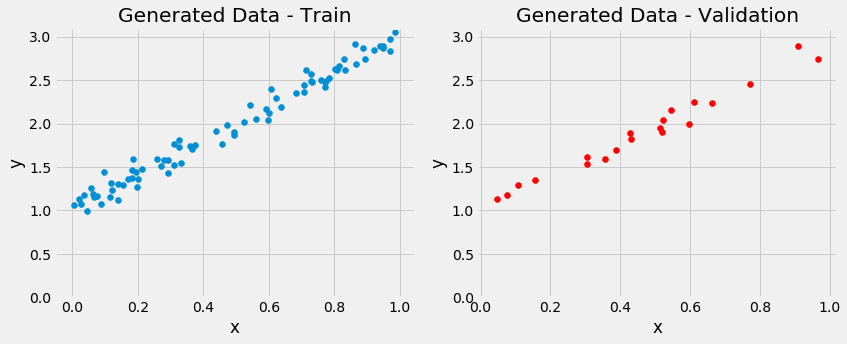

In [5]:
# Code for generating Figure 0.1
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(x_train, y_train)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_ylim([0, 3.1])
ax[0].set_title('Generated Data - Train')
ax[1].scatter(x_val, y_val, c='r')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_ylim([0, 3.1])
ax[1].set_title('Generated Data - Validation')
fig.tight_layout()

## Step 0: Random Initialization

In [6]:
# Step 0 - Initializes parameters "a" and "b" randomly
np.random.seed(42)
b = np.random.randn(1)
w = np.random.randn(1)

print(b, w)

[0.49671415] [-0.1382643]


## Step 1: Compute Model's Predictions

In [7]:
# Step 1 - Computes our model's predicted output - forward pass
yhat = b + w * x_train

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68cb342a50>)

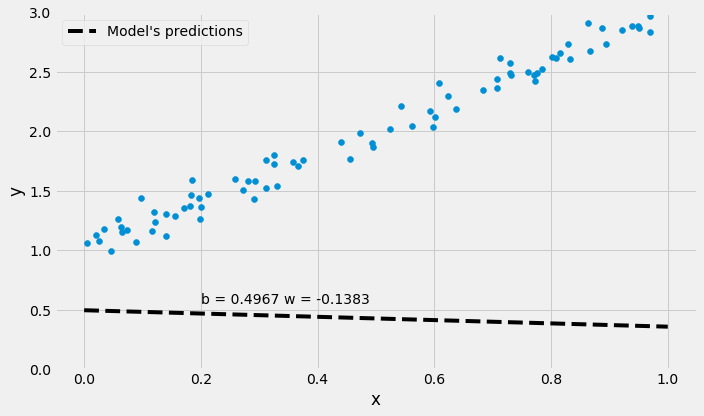

In [8]:
figure2(x_train, y_train, b, w)

## Step 2: Compute the Loss

$$
\Large error_i = y_i - \hat{y_i}
$$

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68cb279950>)

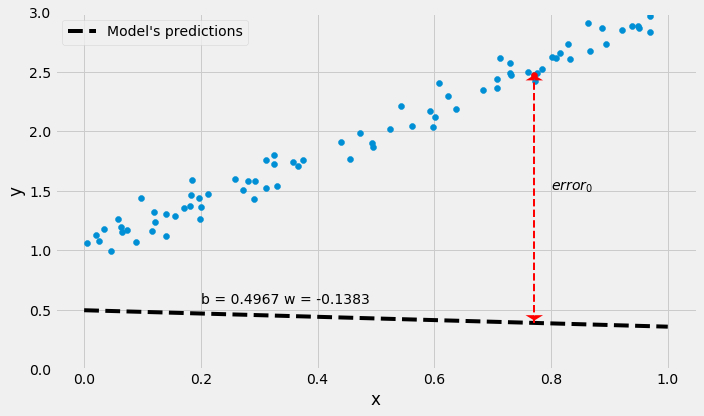

In [9]:
figure3(x_train, y_train, b, w)

$$
\Large
\begin{aligned}
MSE &= \frac{1}{n} \sum_{i=1}^n{error_i}^2
\\
&= \frac{1}{n} \sum_{i=1}^n{(y_i - \hat{y_i})}^2
\\
&= \frac{1}{n} \sum_{i=1}^n{(y_i - b - w x_i)}^2
\end{aligned}
$$

In [10]:
# Step 2 - Computing the loss
# We are using ALL data points, so this is BATCH gradient descent
# How wrong is our model? That's the error! 
error = (y_train - yhat)

# It is a regression, so it computes mean squared error (MSE)
loss = (error ** 2).mean()

print(loss)

2.7421577700550976


### Loss Surface

In [42]:
b_range = np.linspace(true_b - 3, true_b + 3, 101)
w_range = np.linspace(true_w - 3, true_w + 3, 101)
# meshgrid is a handy function that generates a grid
# of b and w values for all combinations
bs, ws = np.meshgrid(b_range, w_range)
bs.shape, ws.shape

((101, 101), (101, 101))

In [44]:
sample_x = x_train[0]
sample_yhat = bs + ws * sample_x
sample_yhat.shape

(101, 101)

In [45]:
all_predictions = np.apply_along_axis(
    func1d=lambda x: bs + ws * x, 
    axis=1, 
    arr=x_train
)
all_predictions.shape

(80, 101, 101)

In [52]:
all_labels = y_train.reshape(-1, 1, 1)
all_labels.shape

(80, 1, 1)

In [57]:
all_errors = (all_predictions - all_labels)
all_errors.shape

(80, 101, 101)

In [53]:
all_losses = (all_errors ** 2).mean(axis=0)
all_losses.shape

(101, 101)

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68c8391090>)

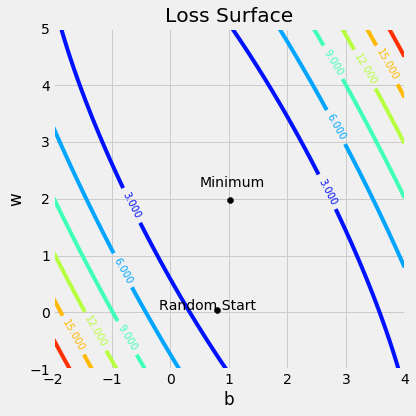

In [39]:
figure4(x_train, y_train, b, w, bs, ws, all_losses)

### Cross Sections

(<Figure size 864x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f68ca487150>,
       dtype=object))

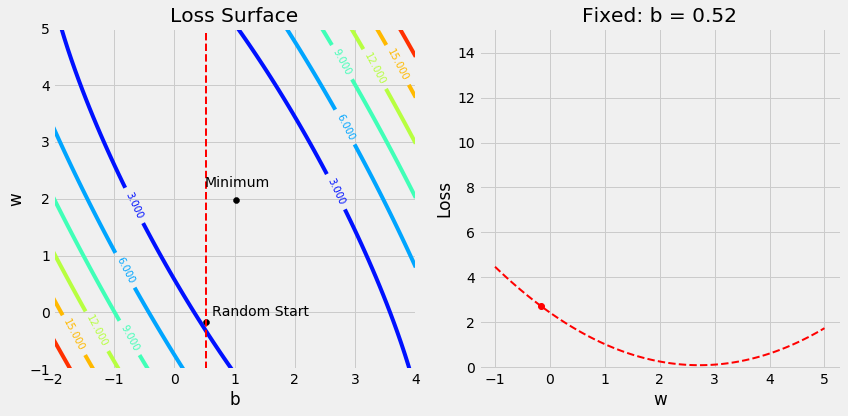

In [14]:
figure5(x_train, y_train, b, w, bs, ws, all_losses)

(<Figure size 864x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f68ca3224d0>,
       dtype=object))

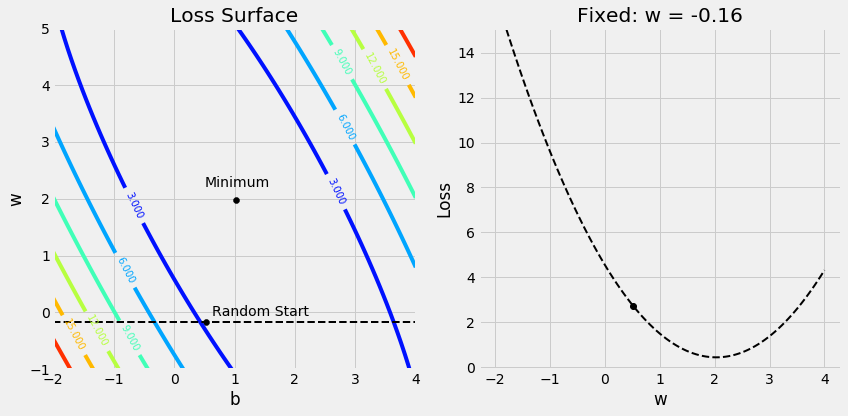

In [15]:
figure6(x_train, y_train, b, w, bs, ws, all_losses)

## Step 3: Compute the Gradients

$$
\large
\begin{aligned}
&\frac{\partial{MSE}}{\partial{b}} = \frac{\partial{MSE}}{\partial{\hat{y_i}}} \cdot \frac{\partial{\hat{y_i}}}{\partial{b}} = \frac{1}{N} \sum_{i=1}^N{2(y_i - b - w x_i) \cdot (-1)} = -2 \frac{1}{N} \sum_{i=1}^N{(y_i - \hat{y_i})}
\\
&\frac{\partial{MSE}}{\partial{w}} = \frac{\partial{MSE}}{\partial{\hat{y_i}}} \cdot \frac{\partial{\hat{y_i}}}{\partial{w}} = \frac{1}{N} \sum_{i=1}^N{2(y_i - b - w x_i) \cdot (-x_i)} = -2 \frac{1}{N} \sum_{i=1}^N{x_i (y_i - \hat{y_i})}
\end{aligned}
$$

In [16]:
# Step 3 - Computes gradients for both "b" and "w" parameters
b_grad = -2 * error.mean()
w_grad = -2 * (x_train * error).mean()
print(b_grad, w_grad)

-3.044811379650508 -1.8337537171510832


### Visualizing the Gradients

(<Figure size 864x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f68ca2b27d0>,
       dtype=object))

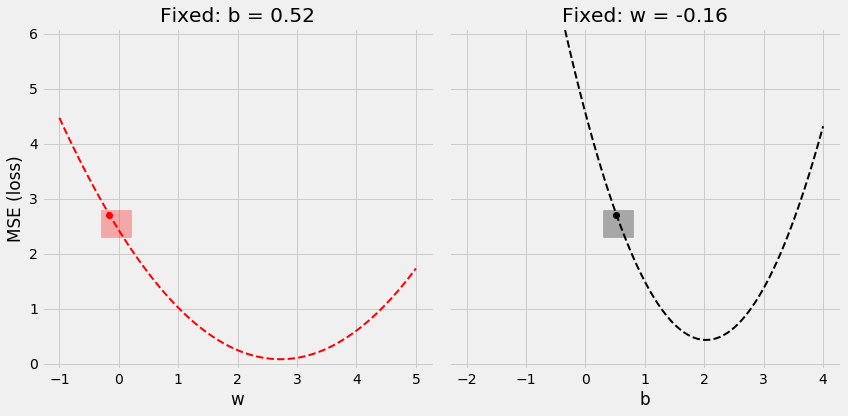

In [17]:
figure7(b, w, bs, ws, all_losses)

(<Figure size 864x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f68ca1c4990>,
       dtype=object))

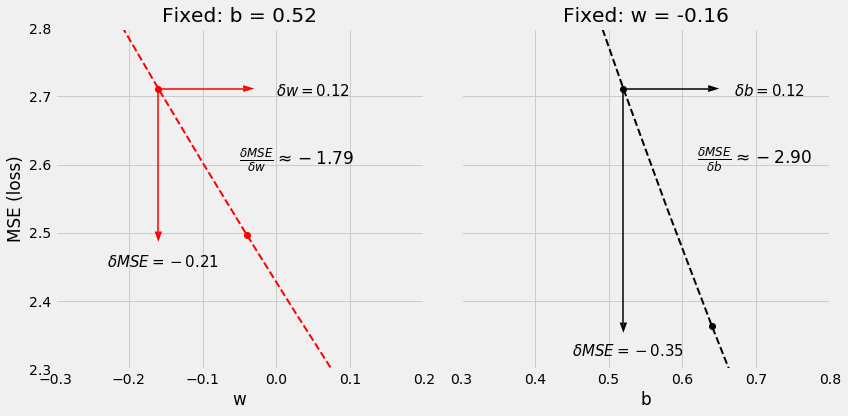

In [18]:
figure8(b, w, bs, ws, all_losses)

### Backpropagation

## Step 4: Update the Parameters

$$
\Large
\begin{aligned}
& b = b - \eta \frac{\partial{MSE}}{\partial{b}}
\\
& w = w - \eta \frac{\partial{MSE}}{\partial{w}}
\end{aligned}
$$

In [19]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1
print(b, w)

# Step 4 - Updates parameters using gradients and the learning rate
b = b - lr * b_grad
w = w - lr * w_grad

print(b, w)

[0.49671415] [-0.1382643]
[0.80119529] [0.04511107]


(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68ca096fd0>)

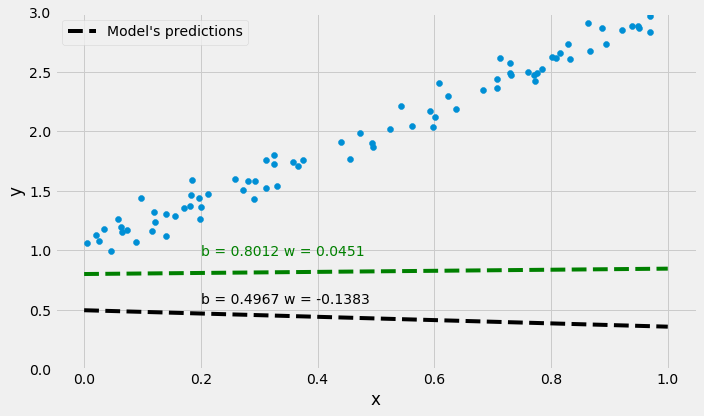

In [20]:
figure9(x_train, y_train, b, w)

### Learning Rate

In [21]:
manual_grad_b = -2.90
manual_grad_w = -1.79

np.random.seed(42)
b_initial = np.random.randn(1)
w_initial = np.random.randn(1)

#### Small Learning Rate

(<Figure size 864x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f68c9fa8b10>,
       dtype=object))

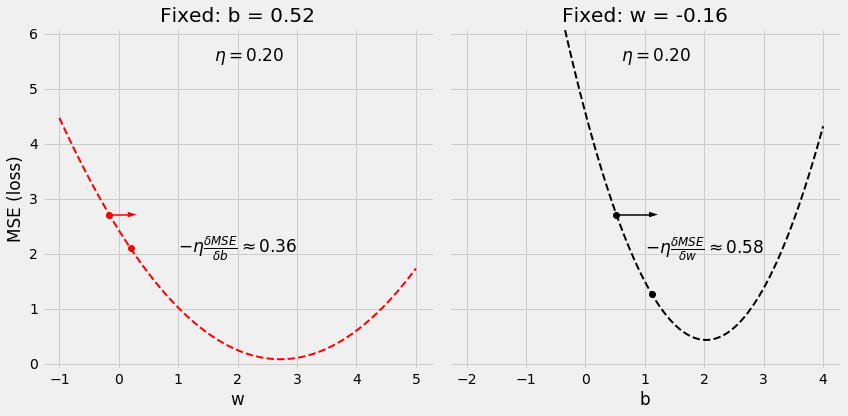

In [22]:
# Learning rate - greek letter "eta" that looks like an "n"
lr = .2

figure10(b_initial, w_initial, bs, ws, all_losses, manual_grad_b, manual_grad_w, lr)

#### Big Learning Rate

(<Figure size 864x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f68c9ebab90>,
       dtype=object))

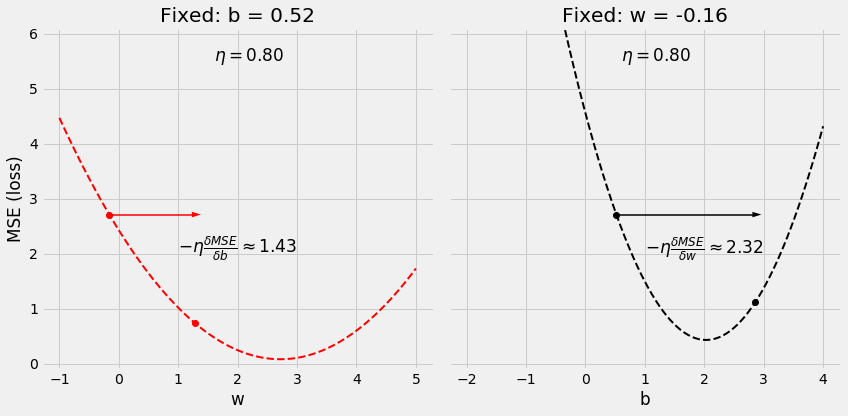

In [23]:
# Learning rate - greek letter "eta" that looks like an "n"
lr = .8

figure10(b_initial, w_initial, bs, ws, all_losses, manual_grad_b, manual_grad_w, lr)

#### Very Big Learning Rate

(<Figure size 864x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f68c8550d90>,
       dtype=object))

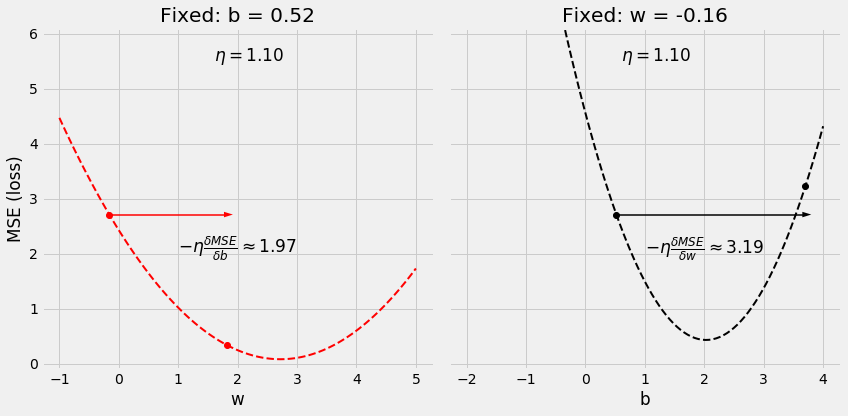

In [24]:
# Learning rate - greek letter "eta" that looks like an "n"
lr = 1.1

figure10(b_initial, w_initial, bs, ws, all_losses, manual_grad_b, manual_grad_w, lr)

#### "Bad" Feature

In [25]:
true_b = 1
true_w = 2
N = 100

# Data Generation
np.random.seed(42)

# We divide w by 10
bad_w = true_w / 10
# And multiply x by 10
bad_x = np.random.rand(N, 1) * 10

# So, the net effect on y is zero - it is still the same as before
y = true_b + bad_w * bad_x + (.1 * np.random.randn(N, 1))

In [26]:
# Generates train and validation sets
# It uses the same train_idx and val_idx as before, but it applies to bad_x
bad_x_train, y_train = bad_x[train_idx], y[train_idx]
bad_x_val, y_val = bad_x[val_idx], y[val_idx]

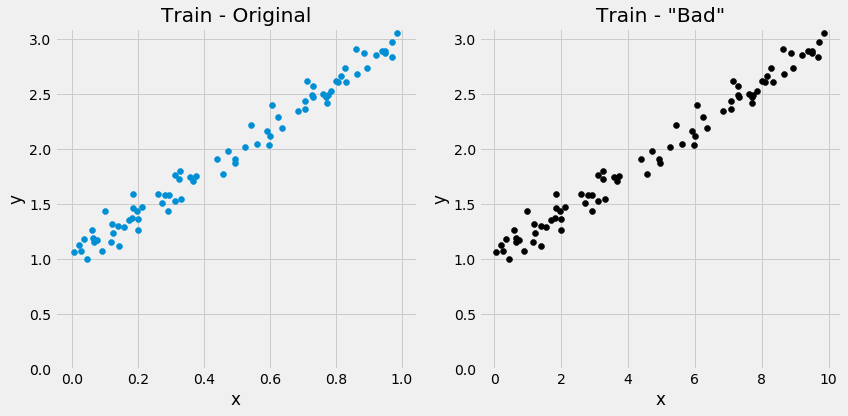

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(x_train, y_train)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_ylim([0, 3.1])
ax[0].set_title('Train - Original')
ax[1].scatter(bad_x_train, y_train, c='k')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_ylim([0, 3.1])
ax[1].set_title('Train - "Bad"')
fig.tight_layout()

In [29]:
# The ranges CHANGED because we are centering at the new minimum, using "bad" data
bad_b_range = np.linspace(-2, 4, 101)
bad_w_range = np.linspace(-2.8, 3.2, 101)
bad_bs, bad_ws = np.meshgrid(bad_b_range, bad_w_range)

(<Figure size 864x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f68c82dd790>,
       dtype=object))

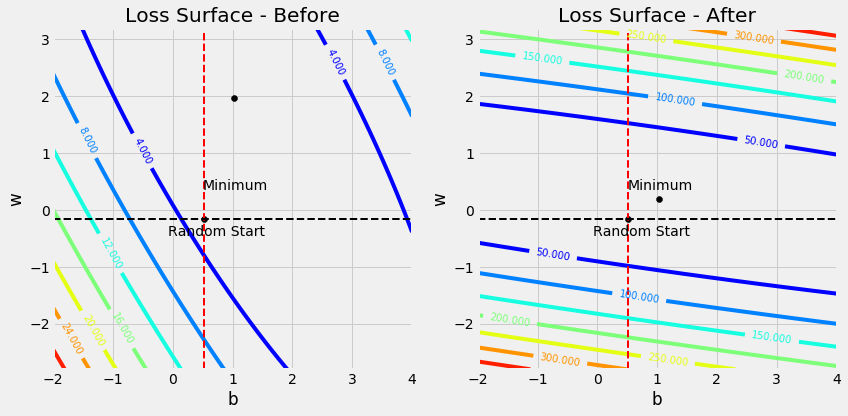

In [30]:
figure14(x_train, y_train, b_initial, w_initial, bad_bs, bad_ws, bad_x_train)

(<Figure size 864x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f68c82dd350>,
       dtype=object))

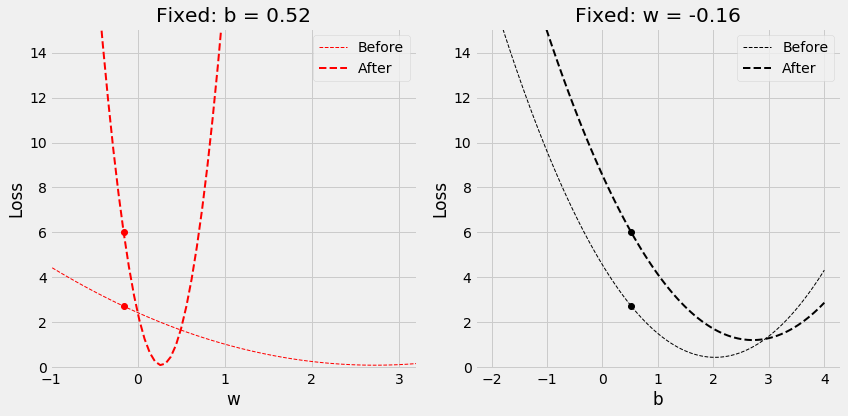

In [31]:
figure15(x_train, y_train, b_initial, w_initial, bad_bs, bad_ws, bad_x_train)

#### StandardScaler

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True)
# We use the TRAIN set ONLY to fit the scaler
scaler.fit(x_train)

# Now we can use the already fit scaler to
# TRANSFORM both TRAIN and VALIDATION sets
scaled_x_train = scaler.transform(x_train)
scaled_x_val = scaler.transform(x_val)

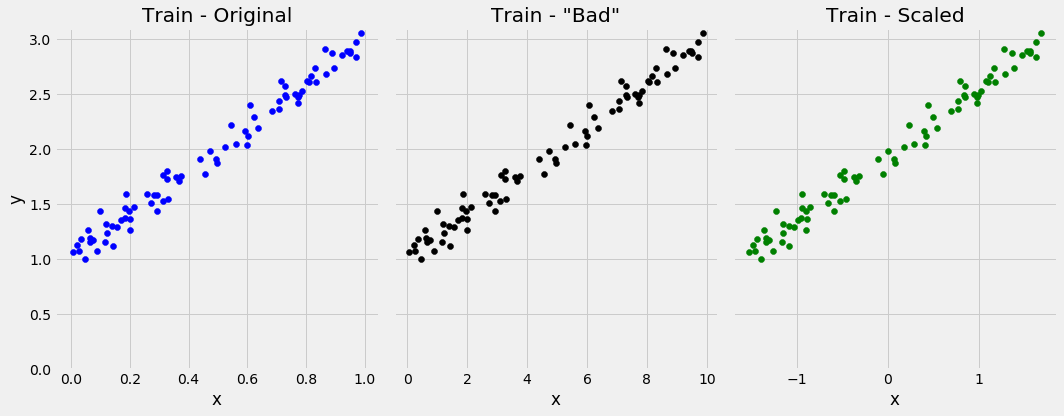

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].scatter(x_train, y_train, c='b')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_ylim([0, 3.1])
ax[0].set_title('Train - Original')
ax[1].scatter(bad_x_train, y_train, c='k')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_ylim([0, 3.1])
ax[1].set_title('Train - "Bad"')
ax[1].label_outer()
ax[2].scatter(scaled_x_train, y_train, c='g')
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')
ax[2].set_ylim([0, 3.1])
ax[2].set_title('Train - Scaled')
ax[2].label_outer()

fig.tight_layout()

In [34]:
# The ranges CHANGED AGAIN because we are centering at the new minimum, using "scaled" data
scaled_b_range = np.linspace(-1, 5, 101)
scaled_w_range = np.linspace(-2.4, 3.6, 101)
scaled_bs, scaled_ws = np.meshgrid(scaled_b_range, scaled_w_range)

(<Figure size 1080x432 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f68ba7cf590>,
       dtype=object))

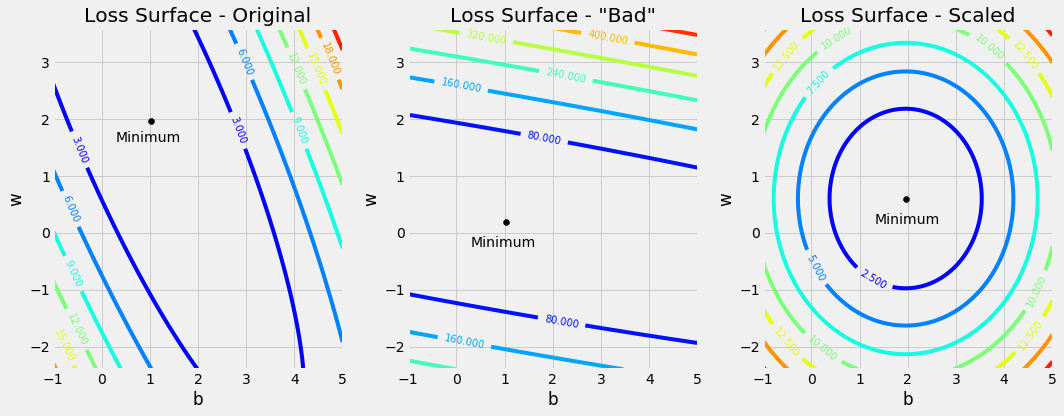

In [35]:
figure17(x_train, y_train, scaled_bs, scaled_ws, bad_x_train, scaled_x_train)

## Step 5: Rinse and Repeat!

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68ba66fad0>)

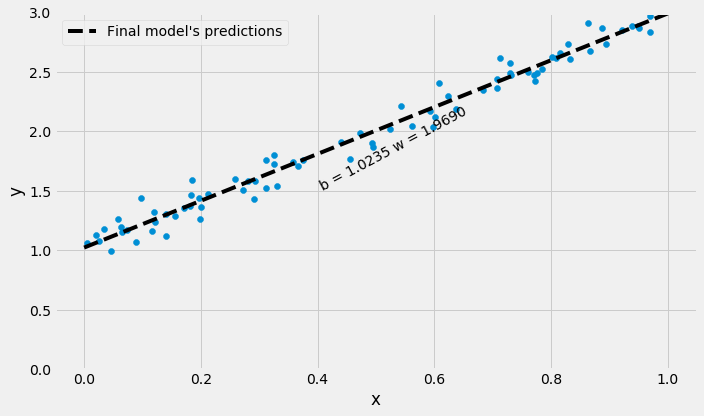

In [36]:
figure18(x_train, y_train)

### The Path of Gradient Descent

Even though the plots are important to illustrate the paths, the corresponding code is beyond the scope of this chapter.

![](./images/paths.png)